In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)


    # Defined Autoencoder
    batch_size = 4096*2
    
    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #adding channel noise
    encoded4 = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(1))[0:tf.shape(x)[0],:])(encoded3)


    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded4)
    cd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(cd_data)

    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded4)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,1), 0,np.sqrt(0))[0:tf.shape(x)[0]])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(8, activation='relu')(data_split)
    decoded = Dense(M, activation='relu')(data_split)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.2)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=50,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(32000, 16)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2)            4           dense_2[0][0]                    
_________________________

32000/32000 [==============================] - 0s 3us/step - loss: 2.0852 - acc: 0.2153 - mean_squared_error: 0.0505
Epoch 36/50
32000/32000 [==============================] - 0s 4us/step - loss: 2.0965 - acc: 0.2113 - mean_squared_error: 0.0509
Epoch 37/50
32000/32000 [==============================] - 0s 4us/step - loss: 2.0937 - acc: 0.2188 - mean_squared_error: 0.0508
Epoch 38/50
32000/32000 [==============================] - 0s 3us/step - loss: 2.0892 - acc: 0.2201 - mean_squared_error: 0.0506
Epoch 39/50
32000/32000 [==============================] - 0s 2us/step - loss: 2.0856 - acc: 0.2250 - mean_squared_error: 0.0505
Epoch 40/50
32000/32000 [==============================] - 0s 3us/step - loss: 2.0708 - acc: 0.2352 - mean_squared_error: 0.0502
Epoch 41/50
32000/32000 [==============================] - 0s 2us/step - loss: 2.0607 - acc: 0.2383 - mean_squared_error: 0.0499
Epoch 42/50
32000/32000 [==============================] - 0s 3us/step - loss: 2.0461 - acc: 0.2494 - mean_sq

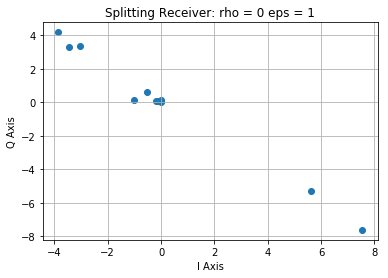

[15.78249]
Es/No: 12 SER: 0.768625 Theor_SER_PAM: 0.5075803579279314
(64000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 16)           272         input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            34          dense_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2)            4           dense_7[0][0]                    
____________________________

64000/64000 [==============================] - 0s 2us/step - loss: 1.8122 - acc: 0.2134 - mean_squared_error: 0.0513
Epoch 40/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.8057 - acc: 0.2186 - mean_squared_error: 0.0511
Epoch 41/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.8013 - acc: 0.2178 - mean_squared_error: 0.0510
Epoch 42/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.7935 - acc: 0.2194 - mean_squared_error: 0.0509
Epoch 43/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.7892 - acc: 0.2196 - mean_squared_error: 0.0508
Epoch 44/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.7859 - acc: 0.2232 - mean_squared_error: 0.0508
Epoch 45/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.7869 - acc: 0.2230 - mean_squared_error: 0.0507
Epoch 46/50
64000/64000 [==============================] - 0s 2us/step - loss: 1.9476 - acc: 0.1961 - mean_sq

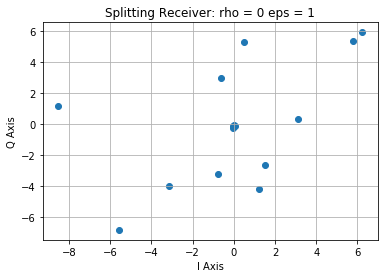

[25.022959]
Es/No: 14 SER: 0.770921875 Theor_SER_PAM: 0.4143940207176103
(128000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 16)           272         input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            34          dense_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2)            4           dense_12[0][0]                   
_______________________

Epoch 39/50
128000/128000 [==============================] - 0s 4us/step - loss: 1.7081 - acc: 0.2364 - mean_squared_error: 0.0502
Epoch 40/50
128000/128000 [==============================] - 0s 3us/step - loss: 2.0709 - acc: 0.1969 - mean_squared_error: 0.0533
Epoch 41/50
128000/128000 [==============================] - 0s 3us/step - loss: 1.8933 - acc: 0.2014 - mean_squared_error: 0.0526
Epoch 42/50
128000/128000 [==============================] - 0s 3us/step - loss: 1.7971 - acc: 0.2454 - mean_squared_error: 0.0516
Epoch 43/50
128000/128000 [==============================] - 0s 3us/step - loss: 1.7853 - acc: 0.2406 - mean_squared_error: 0.0508
Epoch 44/50
128000/128000 [==============================] - 0s 3us/step - loss: 2.5700 - acc: 0.1449 - mean_squared_error: 0.0578
Epoch 45/50
128000/128000 [==============================] - 0s 3us/step - loss: 2.2465 - acc: 0.1577 - mean_squared_error: 0.0560
Epoch 46/50
128000/128000 [==============================] - 1s 4us/step - loss: 1.

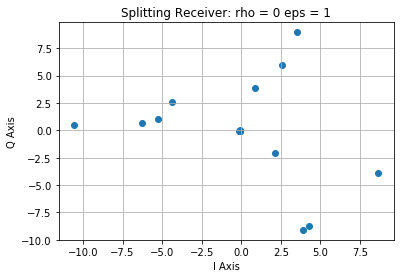

[40.523834]
Es/No: 16 SER: 0.7471640625 Theor_SER_PAM: 0.3123019621637889
(256000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 16)           272         input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2)            34          dense_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 2)            4           dense_17[0][0]                   
______________________

Epoch 39/50
256000/256000 [==============================] - 1s 3us/step - loss: 2.0789 - acc: 0.1940 - mean_squared_error: 0.0512
Epoch 40/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.9745 - acc: 0.2134 - mean_squared_error: 0.0503
Epoch 41/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.9544 - acc: 0.2231 - mean_squared_error: 0.0497
Epoch 42/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.9076 - acc: 0.2291 - mean_squared_error: 0.0497
Epoch 43/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.9388 - acc: 0.2094 - mean_squared_error: 0.0516
Epoch 44/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.8627 - acc: 0.2255 - mean_squared_error: 0.0498
Epoch 45/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.8331 - acc: 0.2356 - mean_squared_error: 0.0491
Epoch 46/50
256000/256000 [==============================] - 1s 3us/step - loss: 1.

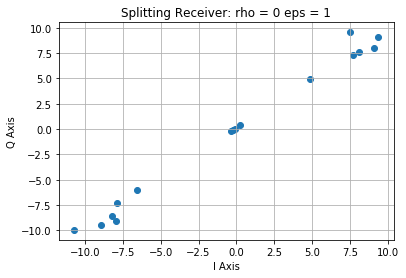

[100.62906]
Es/No: 20 SER: 0.87498828125 Theor_SER_PAM: 0.11723145012290671
(512000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 16)           272         input_5[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            34          dense_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2)            4           dense_22[0][0]                   
____________________

512000/512000 [==============================] - 4s 7us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 39/50
512000/512000 [==============================] - 4s 8us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 40/50
512000/512000 [==============================] - 4s 8us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 41/50
512000/512000 [==============================] - 4s 8us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 42/50
512000/512000 [==============================] - 4s 9us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 43/50
512000/512000 [==============================] - 4s 8us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 44/50
512000/512000 [==============================] - 4s 8us/step - loss: 15.1133 - acc: 0.0623 - mean_squared_error: 0.1172
Epoch 45/50
512000/512000 [==============================] - 4s 8us/step - loss: 15.1133

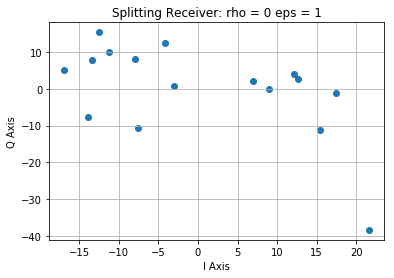

[310.6706]
Es/No: 25 SER: 0.9375546875 Theor_SER_PAM: 0.00597813169126268
(512000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 16)           272         input_6[0][0]                    
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 2)            34          dense_26[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 2)            4           dense_27[0][0]                   
______________________

512000/512000 [==============================] - 3s 6us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1054
Epoch 39/50
512000/512000 [==============================] - 4s 7us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1054
Epoch 40/50
512000/512000 [==============================] - 3s 6us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1055
Epoch 41/50
512000/512000 [==============================] - 3s 6us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1056
Epoch 42/50
512000/512000 [==============================] - 3s 7us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1056
Epoch 43/50
512000/512000 [==============================] - 4s 7us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1057
Epoch 44/50
512000/512000 [==============================] - 4s 7us/step - loss: 14.0959 - acc: 0.1255 - mean_squared_error: 0.1057
Epoch 45/50
512000/512000 [==============================] - 4s 7us/step - loss: 14.0959

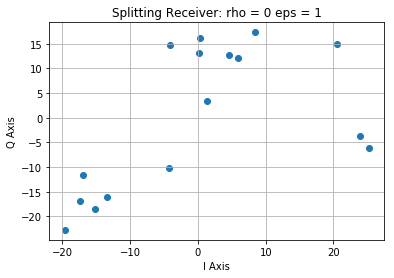

[398.67218]
Es/No: 26 SER: 0.874751953125 Theor_SER_PAM: 0.0020709317187892974


In [5]:
EsNodB_range = [12,14,16,20,25,26]
N_array=[32000,64000,128000,256000,512000,512000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

noise_std = np.sqrt(1)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    # generating data for checking SER
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_PAM:',theor_ser[n])
    

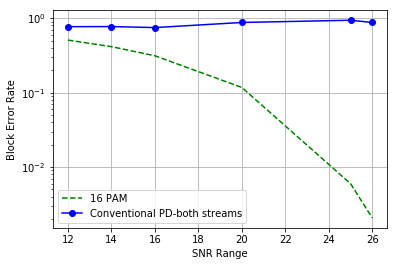

In [6]:
plt.plot(EsNodB_range, theor_ser, 'g--',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Conventional PD-both streams')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
ser

[0.768625,
 0.770921875,
 0.7471640625,
 0.87498828125,
 0.9375546875,
 0.874751953125]